<a href="https://colab.research.google.com/github/farfaness/dimension_reduction_and_clutering/blob/master/slide_detector_PCA_Kmeans_CH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Nous allons utiliser l'ACP et le clustering pour traiter une vidéo ! 

Nous allons programmer un "détecteur de slides". La vidéo que nous utilisons est celle d'un cours magistral en amphithéâtre, dans laquelle le professeur utilise un diaporama composé de plusieurs slides.
Notre objectif sera d'extraire les différentes slides grâce à une analyse d'image.

Une vidéo est un enchaînement rapide d'images fixes. Quand une slide est affichée à l'écran durant 20 secondes, toutes les images contenues dans ces 20 secondes sont semblables (même si le professeur bouge un peu). On a donc des images similaires (dues aux slides immobiles), même si un peu différentes (dues au mouvement du professeur).

On va donc détecter les images similaires pour en extraire les différentes slides de la présentation ! Pour détecter les images similaires, nous utiliserons du clustering.

Mais nous serons également obligés de réduire les dimensions de nos données : nous ferons ceci grâce à l'ACP.

source : https://openclassrooms.com/fr/courses/4525281-realisez-une-analyse-exploratoire-de-donnees/exercises/2657#/step1

Les données : La vidéo dure 1 h 36, et contient 174 053 images. Une image est composée de pixels. Chaque image mesure 640 pixels en largeur et 360 en hauteur, soit 230 400 pixels ! En plus, la couleur d'un pixel est encodée selon 3 niveaux : rouge, vert et bleu. On a donc 174 053 * 230 400 * 3 = 120 305 433 600 unités d'information dans cette vidéo !

# Réalisez un détecteur de slides grâce à de l'analyse d'image

## Fonctions outils

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab
from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# dimensions des images
height = 72
width = 128

# Fonctions d'affichage des images
def display_image(video, image_position):
    try:
        img = video[video.position == image_position]
        url = img.index.values[0]
        img = img.values[0]
    except IndexError:
        raise Exception("La position demandée n'est pas disponible")
    img = img[1:] # On supprime la première colonne qui correspond à la position de l'image (en secondes)
    
    display_with_pylab(img, url)
    
def display_compressed_image(pca, std_scaler, X_projected, image_position, list_of_positions):
    try:
        i = np.where(list_of_positions == image_position)[0][0]
    except IndexError:
        raise Exception("La position demandée n'est pas disponible")
        
    compressed_img = X_projected[i]
    img = decompress_image(pca, std_scaler, compressed_img)
    url = list_of_positions.index[i]
    
    display_with_pylab(img, url)

def display_with_pylab(img, url=None):
    img = img.reshape(height, width, 3) # On remet l'image sous forme d'un numpy array de height*width*3
    img = img * 4 # On remet l'échelle des couleurs de 0 à 256
    img = np.array(img, dtype=np.float64)
    if url:
        print(url)
    fig = pylab.figure()
    pylab.imshow(img.astype(np.uint8))
    plt.show()   
    
def decompress_image(pca, std_scaler, compressed_img):
    img = pca.inverse_transform(compressed_img)
    img = std_scaler.inverse_transform(img)
    return img

## Chargement des données

Nous importons le CSV et stockons la matrice dans un array numpy appelé X. Cette opération peut prendre quelques secondes. Ensuite, nous affichons l'image de la 150e seconde.

In [0]:
# To download the dataset from my google drive : mout my drive
from google.colab import drive
drive.mount('/content/drive')

In [5]:
pwd

'/content/drive/My Drive/reduction_dimension_et_clustering'

In [4]:
ls

bag_of_words.csv                   PCA.ipynb
courses_info.csv                   Principal_Components_Analysis.ipynb
hierarchical_classification.ipynb  slide_detector.ipynb
my_courses.csv                     video.csv
mystery.csv


https://youtu.be/uV5hmpzmWsU?t=150s


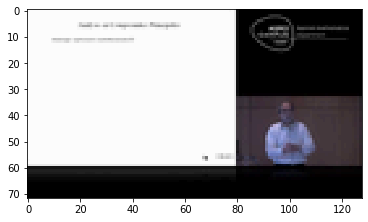

                                      position   0   1  ...  27645  27646  27647
https://youtu.be/uV5hmpzmWsU?t=0s            0   0   0  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=3s            3   0   0  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=6s            6   0   0  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=9s            9   0   0  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=12s          12   0   0  ...      0      0      0
...                                        ...  ..  ..  ...    ...    ...    ...
https://youtu.be/uV5hmpzmWsU?t=5787s      5787  62  62  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=5790s      5790  62  62  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=5793s      5793   9   9  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=5796s      5796   9   9  ...      0      0      0
https://youtu.be/uV5hmpzmWsU?t=5799s      5799   9   9  ...      0      0      0

[1934 rows x 27649 columns]

In [8]:
# Chargement de la vidéo (peut prendre quelques secondes)
try:
    video
except NameError:
    video = pd.read_csv("/content/drive/My Drive/reduction_dimension_et_clustering/video.csv", index_col= 0)
    
display_image(video,150)
print(video)

X = video.values[:,1:] # On supprime la première colonne qui correspond à la position de l'image (en secondes)

## ACP et réduction de dimensions

Comme il y a beaucoup de colonnes, nous réduisons les données grâce à une ACP après centrage-réduction des données. Nous remplaçons donc toutes nos colonnes par les  n_comp  premières composantes principales, pour avoir un tableau de données avec  n_comp  colonnes.

In [0]:
n_comp = 60

# centrage-réduction
X = X.astype(np.float64) # conversion des nombres entiers en nombres décimaux (float) : necessaire pour le StandardScaler
std_scaler = preprocessing.StandardScaler().fit(X)

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [0]:
X_scaled = std_scaler.transform(X)

In [0]:
# Calcul des composantes principales
pca = decomposition.PCA(n_components= n_comp)

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [12]:
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=60, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

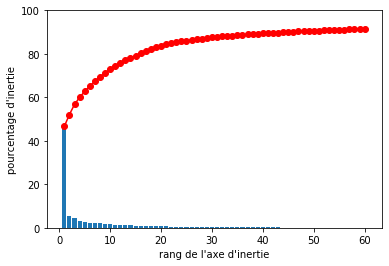

In [13]:
X_projected = pca.transform(X_scaled)

# Affichage des éboulis
eboulis = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(eboulis))+1, eboulis)
plt.plot(np.arange(len(eboulis))+1, eboulis.cumsum(),c="red",marker='o')
plt.ylim(0,100)
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.show()

Remarquez que nous avons ici effectué une compression de vidéo ! Il existe des formats informatiques d'images ou de vidéos compressées (jpeg, mp4, etc.). Certains de ceux-ci se basent sur des méthodes de compressions similaires à l'ACP !

Le calcul des composantes principales peut prendre ici plusieurs secondes, soyez patient. ;)

Après compression de la vidéo, on a forcément perdu en qualité. Affichons l'image de la 150e seconde pour voir cette perte de qualité :

https://youtu.be/uV5hmpzmWsU?t=150s


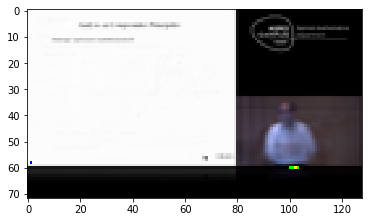

In [14]:
display_compressed_image(pca, std_scaler, X_projected, 150, video["position"])

En affichant les individus projetés sur les premiers plans factoriels, on voit déjà quelques groupes d'images similaires.

Pour les visionner, rendez-vous à cette URL, https://www.youtube.com/watch?v=uV5hmpzmWsU?t=[...]s, en remplaçant le [...] par l'identifiant du point à visualiser. Cet identifiant correspond à la position de l'image dans la vidéo ; il est donné en secondes. Vous pouvez vérifier si deux points proches correspondent à deux images qui se ressemblent.

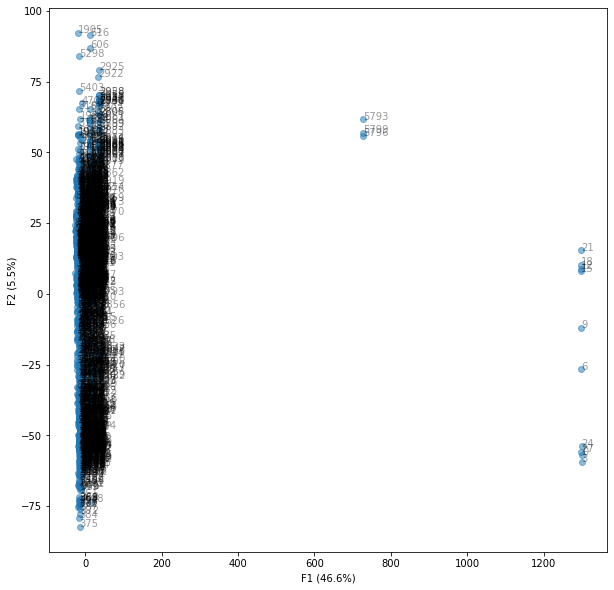

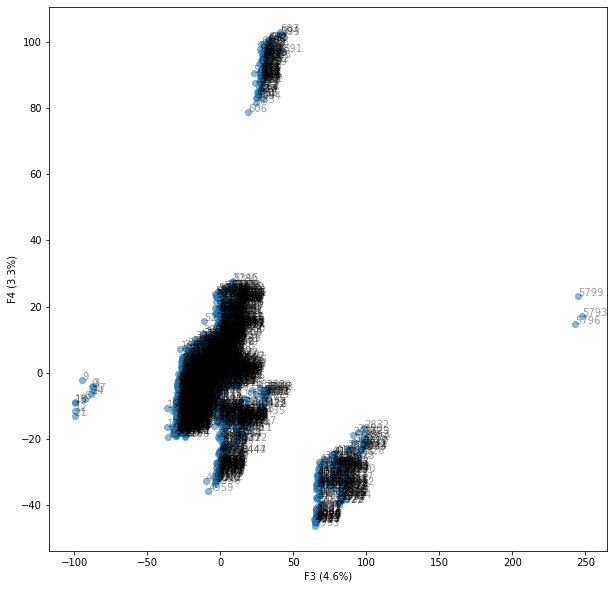

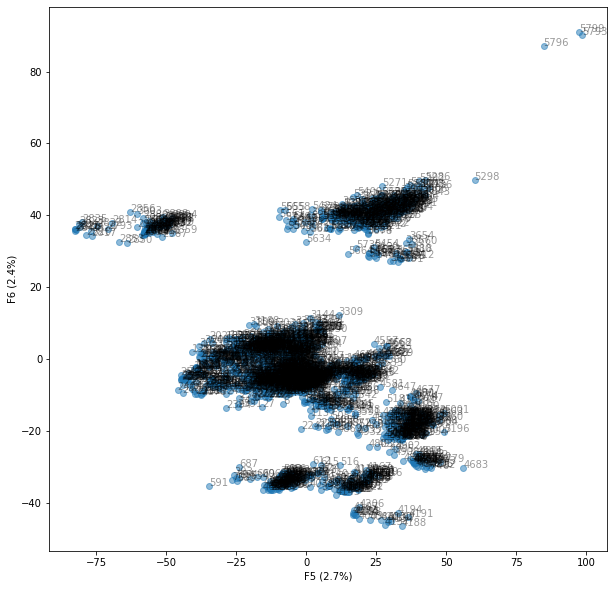

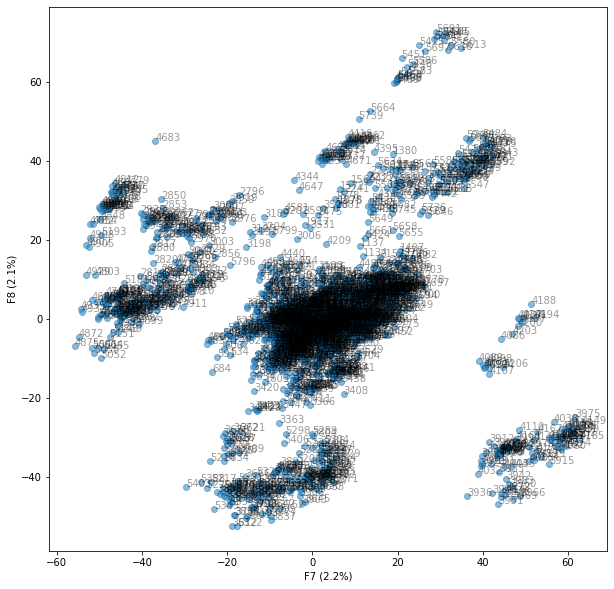

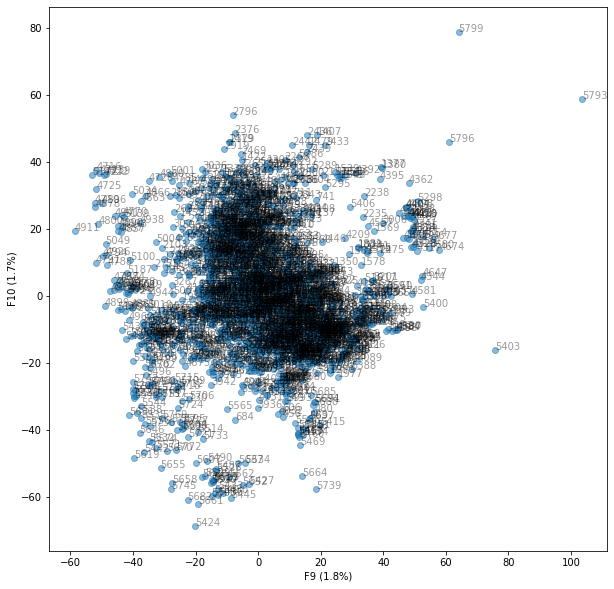

In [15]:
# Affichage des 5 premiers plans factoriels
for d1,d2 in [(0,1),(2,3),(4,5),(6,7),(8,9)]:
    if d2 < n_comp:
        fig = plt.figure(figsize=(10,10))
        plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha= 0.5)
        
        # On identifie les images par leur position dans la vidéo (en secondes)
        for i in range(len(X_projected)):
            plt.text(X_projected[i, d1], X_projected[i, d2], video["position"][i], alpha= 0.4)

        # nom des axes
        plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
        plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
        
        plt.show()

## Clustering

Nous allons regrouper les images similaires. L'idéal serait d'avoir un groupe par slide différente.

Nous allons donc effectuer une classification hiérarchique et afficher le dendrogramme pour choisir le nombre de classes.

Cependant, il y a trop d'individus (trop d'images) pour effectuer une C.H. rapidement. Nous allons donc d'abord effectuer un clustering avec k-means afin de trouver 300 clusters, en espérant que le professeur n'ait pas plus de 300 slides. Il est fort probable qu'après l'application du k-means, plusieurs clusters correspondent à une même slide : c'est là que la classification hiérarchique sera utile afin de regrouper les clusters correspondant à une même slide.

Remarquons qu'ici, on applique le k-means aux données compressées après ACP, c'est-à-dire à X_projected.

In [0]:
km = KMeans(n_clusters= 300)

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [17]:
km.fit(X_projected)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=300, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
clusters_kmeans = km.labels_
centroids_after_kmeans = km.cluster_centers_
print(centroids_after_kmeans.shape) # 300 centres de n_comp dimensions

(300, 60)


Comme les centres de classes sont des points qui ont le même nombre de dimensions (n_comp dimensions) que nos images compressées, on peut afficher ces centres comme des images !

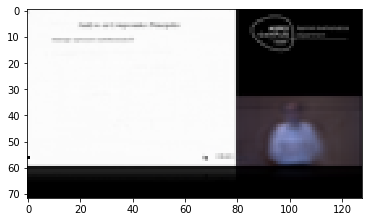

In [19]:
img = decompress_image(pca, std_scaler, centroids_after_kmeans[3]) # On choisit au hasard le cluster numéro 4
display_with_pylab(img)

Nous allons maintenant effectuer la classification hiérarchique sur les 300 clusters. Le professeur a environ 40 slides différentes. Coupons donc l'arbre en 40 clusters :

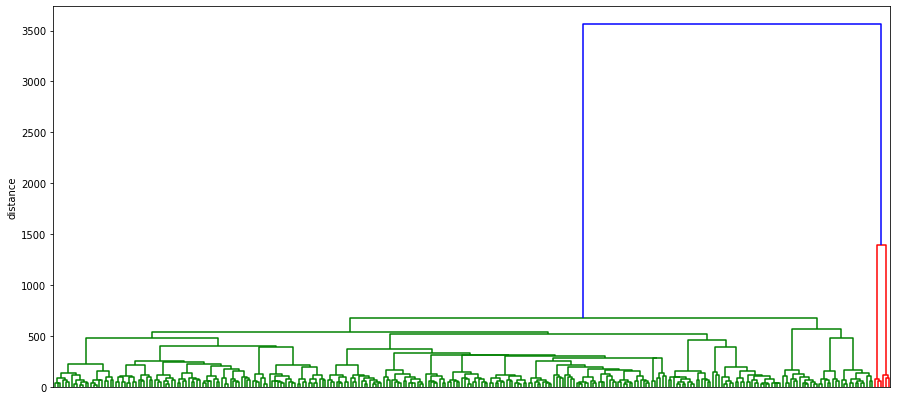

In [20]:
Z = linkage(centroids_after_kmeans, 'ward')

plt.figure(figsize=(15, 7))
plt.ylabel('distance')
dendrogram(Z, no_labels=True)
plt.show()

<span style="color:#B11D1D">__**Code à compléter :**__</span>

In [0]:
final_clusters = fcluster(Z, 40, criterion='maxclust')

In [22]:
print(final_clusters)

[18 39 26 24 38 40 36 35 29  2 33 17 13 21  1  9 15 11 19 29 20  3 12 31
  5 14 28 20 36 10 29 27 10 17 34  1  6  8 25 21 26 17  7 32 33 30  2  1
  6 15 37 13 38  1 20 35 19 26 18  1 19 33 11 38 17 17 35  2 15 16 12 10
 11  4 14 37 19 26 36 38  9 26 31  3 29 38 20 20 25 21 16 25 36 29 29  6
  5 24 29 19  7 29  3  1  4  5 11  1  9 35 18 33 12 24 13 26 17 29 11 15
 15 21 28 19 20  4 21 33 29 31 17 24 31 25 33 24 38 20 15 26 14 33  5 28
 39 36  9  8  6 29 19 40 16 11 30  6 28 18 35 30 26 34  3 15 10 21 29  2
 14 36  1  5 15  2 23 19 22 25  9 36 29 18 18 19  7 17  6 26 23 19  3 20
 20 19  9 19 35 33 32 34  3 38 25 24 35 19 21 33 21 32  1 38 33 14 11 37
 14 13 35  3 35 18  1 20  9 23 29  1 40 36  7 38  9 17 12  7 15 20  5 29
 33 22 22 26 17  6 20 33 25 39 10 15 24 13 10  1 15  7 18  4  2 26 23 21
 17 11 19 14 17 32  2 13 11  3  4 15 27 24 22 35 19 20 20  1 33  6  6  7
 26 14 29  2 11  5  4  5 31  8 13  2]


On arrive ainsi à définir quelle image appartient à quel cluster final. Pour chaque cluster, on pioche au hasard une image (on peut prendre par exemple celle qui apparaît en premier), et on l'affiche. En théorie, on ne devrait donc afficher qu'une image par slide. Nous avons atteint notre objectif !

## Résultat

On affiche aussi l'image moyenne du cluster. Elle représente une "image moyenne" composée de plusieurs images. Sur celles-ci, les objets fixes seront nets, et les objets mobiles seront flous. Les slides seront donc nettement visibles !

------------------------------ 
Slide n°  1
Première image :
https://youtu.be/uV5hmpzmWsU?t=4686s


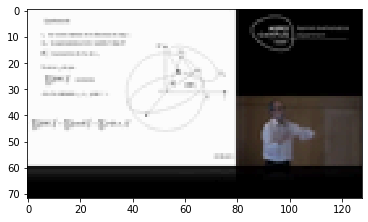

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :119)


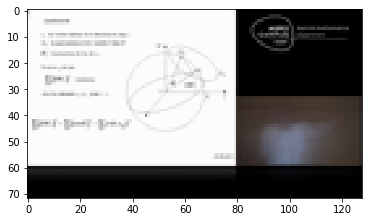

------------------------------ 
Slide n°  2
Première image :
https://youtu.be/uV5hmpzmWsU?t=4683s


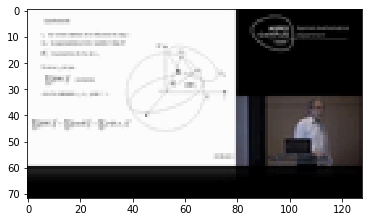

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :53)


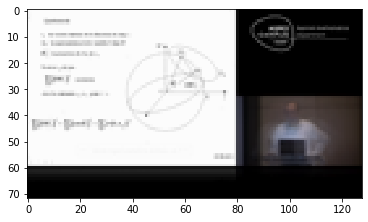

------------------------------ 
Slide n°  3
Première image :
https://youtu.be/uV5hmpzmWsU?t=1701s


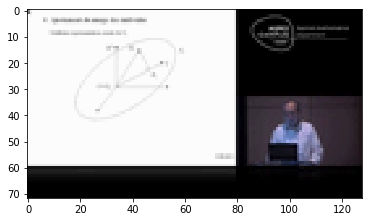

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :42)


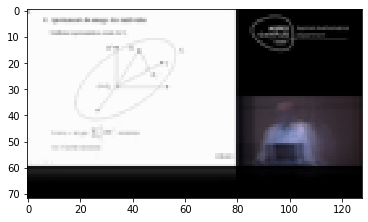

------------------------------ 
Slide n°  4
Première image :
https://youtu.be/uV5hmpzmWsU?t=1569s


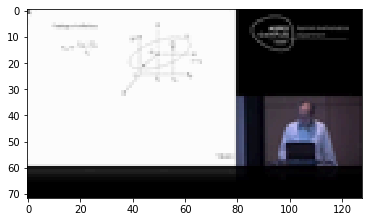

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :14)


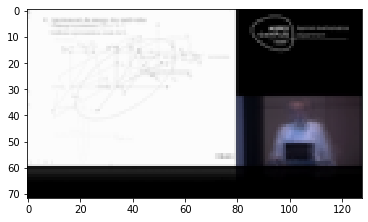

------------------------------ 
Slide n°  5
Première image :
https://youtu.be/uV5hmpzmWsU?t=3453s


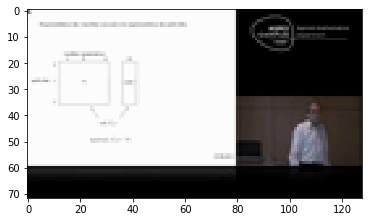

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :38)


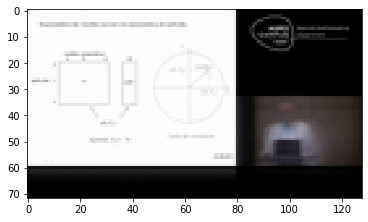

------------------------------ 
Slide n°  6
Première image :
https://youtu.be/uV5hmpzmWsU?t=1518s


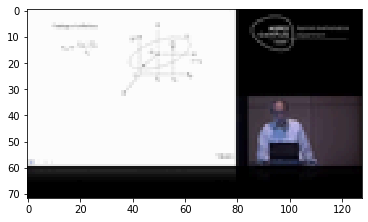

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :46)


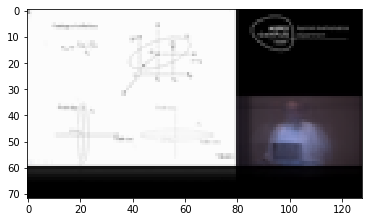

------------------------------ 
Slide n°  7
Première image :
https://youtu.be/uV5hmpzmWsU?t=2136s


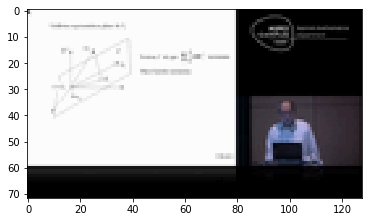

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :26)


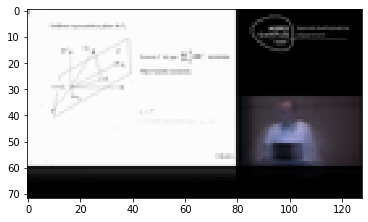

------------------------------ 
Slide n°  8
Première image :
https://youtu.be/uV5hmpzmWsU?t=2529s


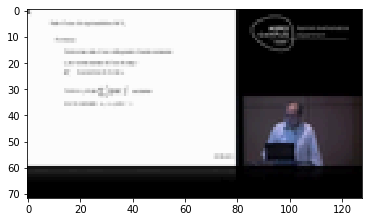

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :19)


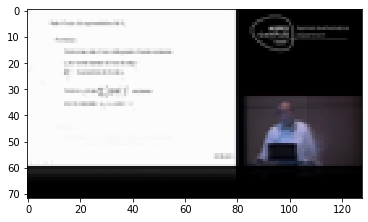

------------------------------ 
Slide n°  9
Première image :
https://youtu.be/uV5hmpzmWsU?t=312s


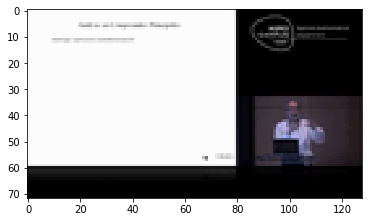

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :36)


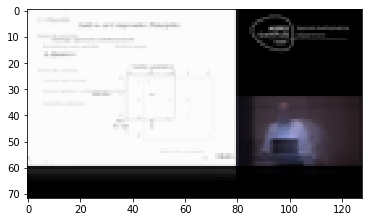

------------------------------ 
Slide n°  10
Première image :
https://youtu.be/uV5hmpzmWsU?t=3363s


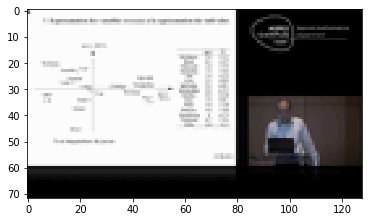

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :29)


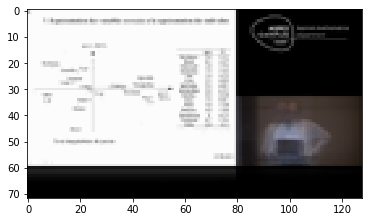

------------------------------ 
Slide n°  11
Première image :
https://youtu.be/uV5hmpzmWsU?t=4308s


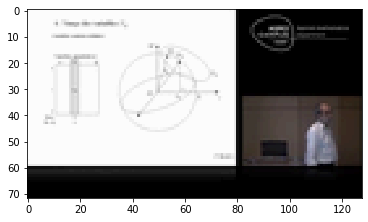

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :67)


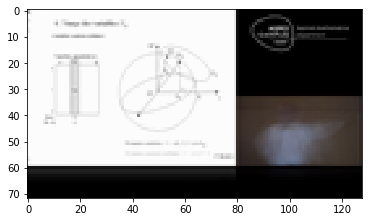

------------------------------ 
Slide n°  12
Première image :
https://youtu.be/uV5hmpzmWsU?t=4314s


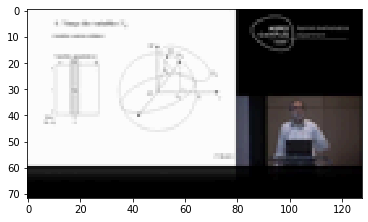

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :30)


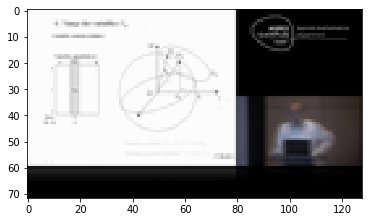

------------------------------ 
Slide n°  13
Première image :
https://youtu.be/uV5hmpzmWsU?t=4209s


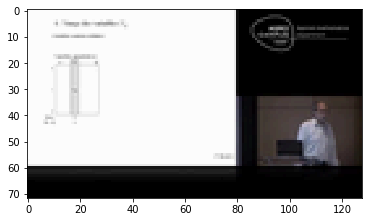

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :33)


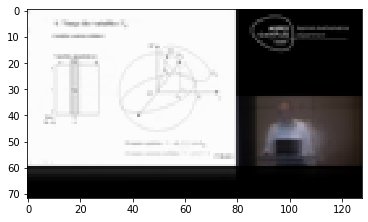

------------------------------ 
Slide n°  14
Première image :
https://youtu.be/uV5hmpzmWsU?t=1176s


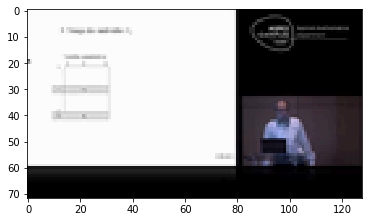

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :40)


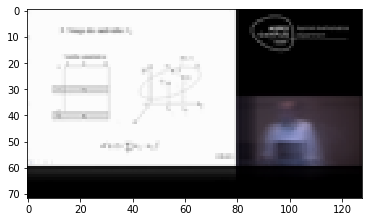

------------------------------ 
Slide n°  15
Première image :
https://youtu.be/uV5hmpzmWsU?t=1179s


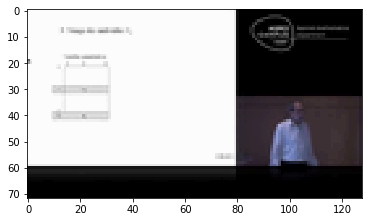

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :71)


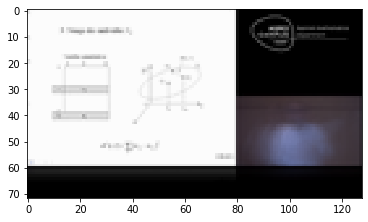

------------------------------ 
Slide n°  16
Première image :
https://youtu.be/uV5hmpzmWsU?t=3006s


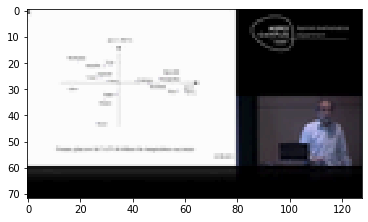

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :16)


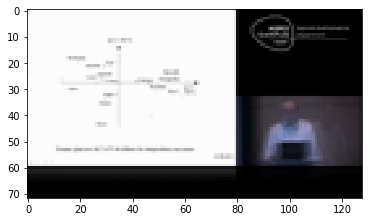

------------------------------ 
Slide n°  17
Première image :
https://youtu.be/uV5hmpzmWsU?t=3009s


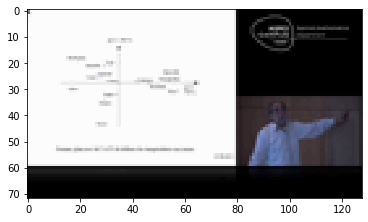

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :103)


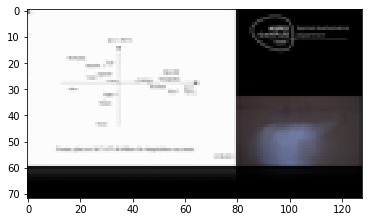

------------------------------ 
Slide n°  18
Première image :
https://youtu.be/uV5hmpzmWsU?t=2679s


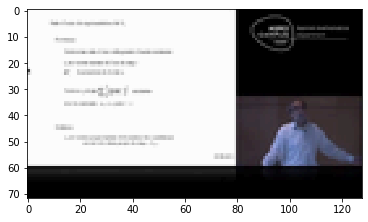

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :38)


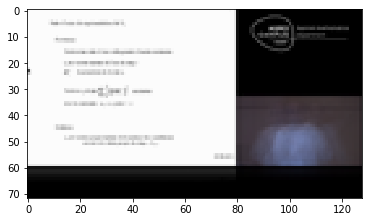

------------------------------ 
Slide n°  19
Première image :
https://youtu.be/uV5hmpzmWsU?t=2142s


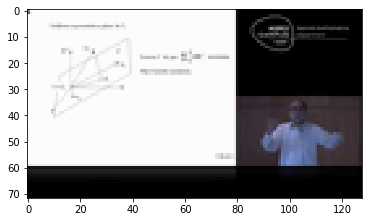

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :84)


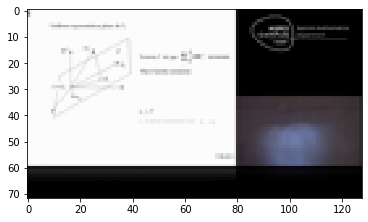

------------------------------ 
Slide n°  20
Première image :
https://youtu.be/uV5hmpzmWsU?t=1707s


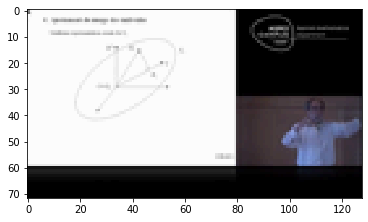

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :95)


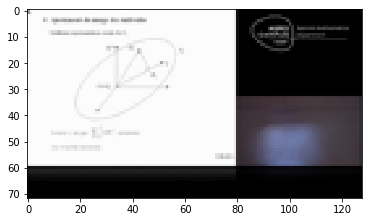

------------------------------ 
Slide n°  21
Première image :
https://youtu.be/uV5hmpzmWsU?t=897s


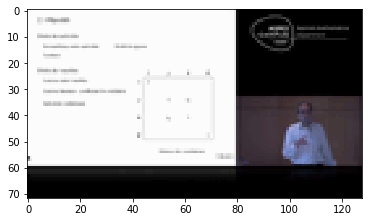

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :83)


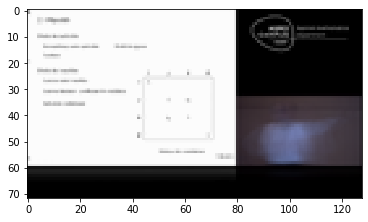

------------------------------ 
Slide n°  22
Première image :
https://youtu.be/uV5hmpzmWsU?t=963s


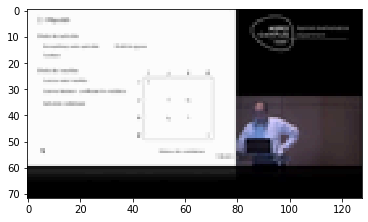

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :4)


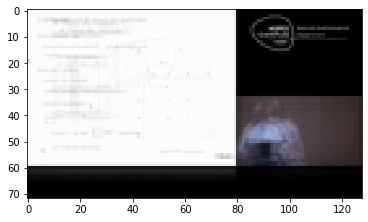

------------------------------ 
Slide n°  23
Première image :
https://youtu.be/uV5hmpzmWsU?t=711s


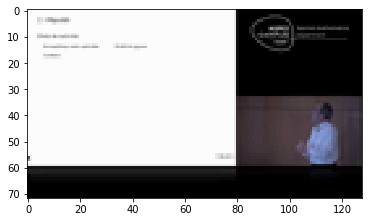

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :6)


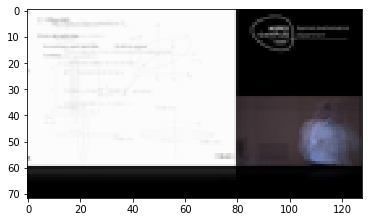

------------------------------ 
Slide n°  24
Première image :
https://youtu.be/uV5hmpzmWsU?t=51s


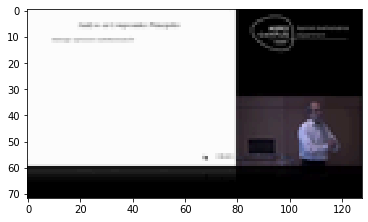

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :90)


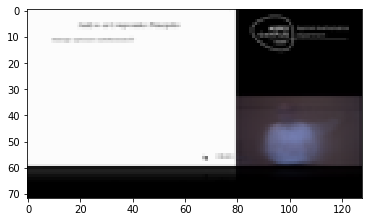

------------------------------ 
Slide n°  25
Première image :
https://youtu.be/uV5hmpzmWsU?t=3450s


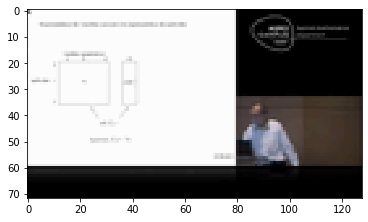

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :39)


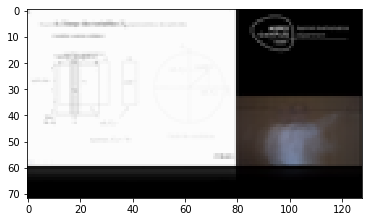

------------------------------ 
Slide n°  26
Première image :
https://youtu.be/uV5hmpzmWsU?t=714s


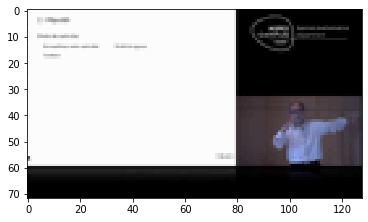

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :107)


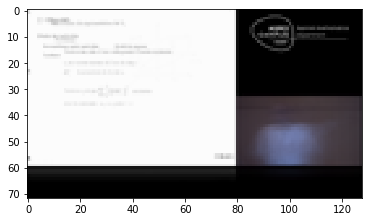

------------------------------ 
Slide n°  27
Première image :
https://youtu.be/uV5hmpzmWsU?t=30s


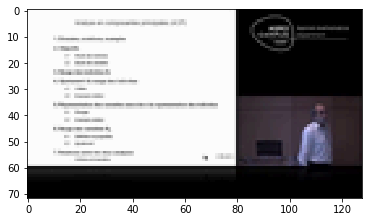

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :7)


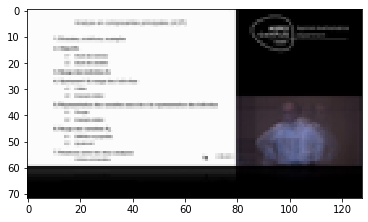

------------------------------ 
Slide n°  28
Première image :
https://youtu.be/uV5hmpzmWsU?t=1134s


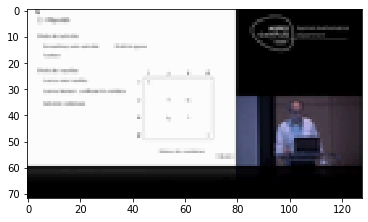

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :12)


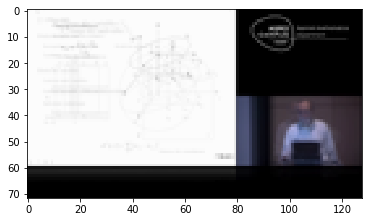

------------------------------ 
Slide n°  29
Première image :
https://youtu.be/uV5hmpzmWsU?t=5412s


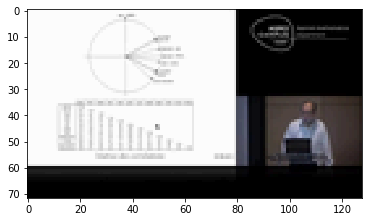

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :126)


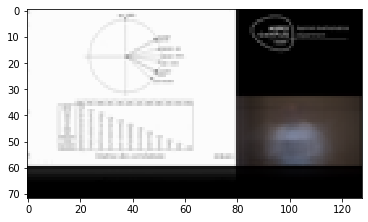

------------------------------ 
Slide n°  30
Première image :
https://youtu.be/uV5hmpzmWsU?t=1905s


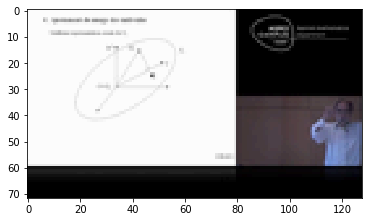

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :4)


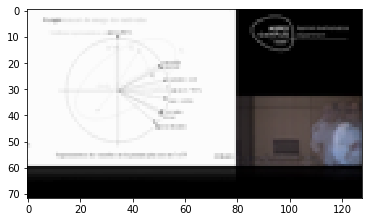

------------------------------ 
Slide n°  31
Première image :
https://youtu.be/uV5hmpzmWsU?t=3606s


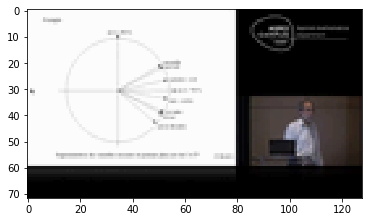

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :46)


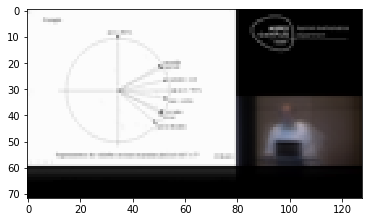

------------------------------ 
Slide n°  32
Première image :
https://youtu.be/uV5hmpzmWsU?t=3639s


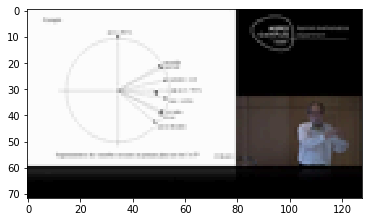

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :20)


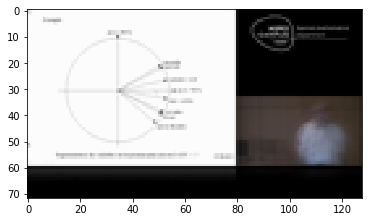

------------------------------ 
Slide n°  33
Première image :
https://youtu.be/uV5hmpzmWsU?t=3609s


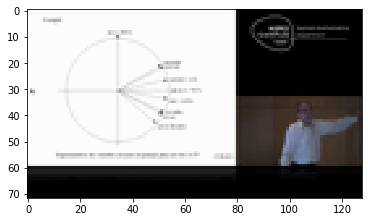

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :104)


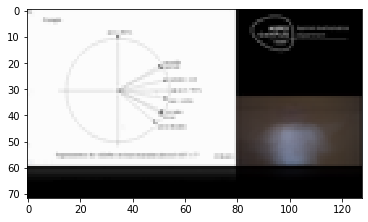

------------------------------ 
Slide n°  34
Première image :
https://youtu.be/uV5hmpzmWsU?t=399s


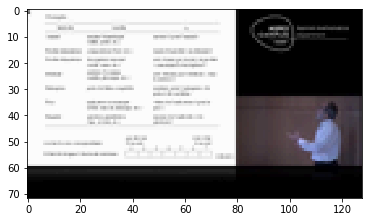

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :11)


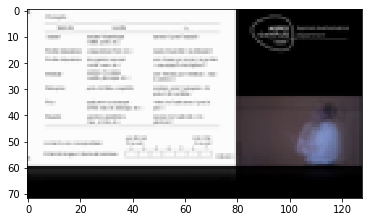

------------------------------ 
Slide n°  35
Première image :
https://youtu.be/uV5hmpzmWsU?t=393s


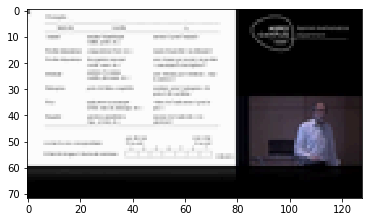

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :93)


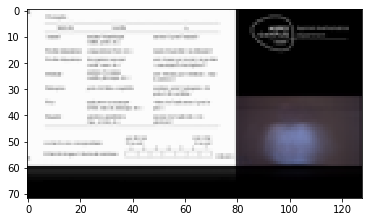

------------------------------ 
Slide n°  36
Première image :
https://youtu.be/uV5hmpzmWsU?t=2793s


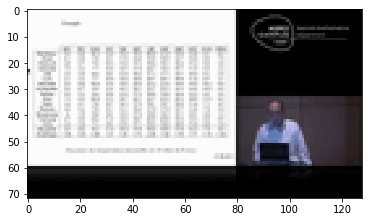

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :71)


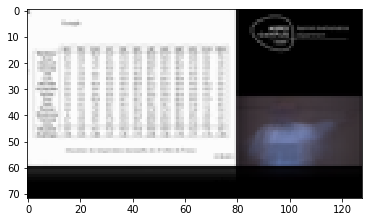

------------------------------ 
Slide n°  37
Première image :
https://youtu.be/uV5hmpzmWsU?t=4086s


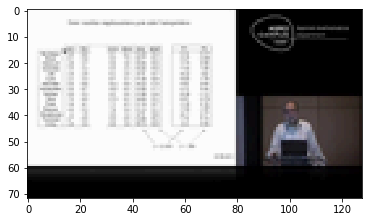

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :17)


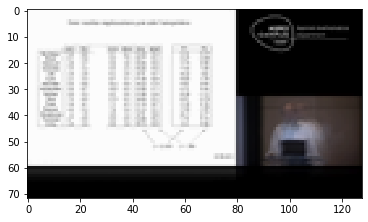

------------------------------ 
Slide n°  38
Première image :
https://youtu.be/uV5hmpzmWsU?t=3912s


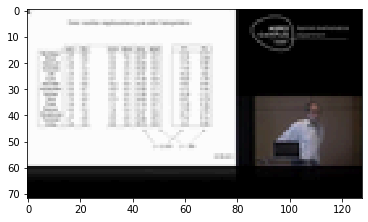

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :82)


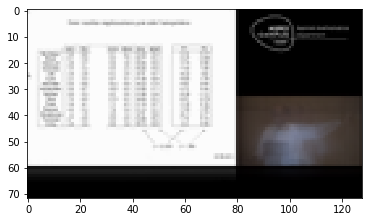

------------------------------ 
Slide n°  39
Première image :
https://youtu.be/uV5hmpzmWsU?t=0s


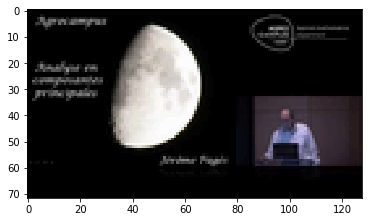

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :10)


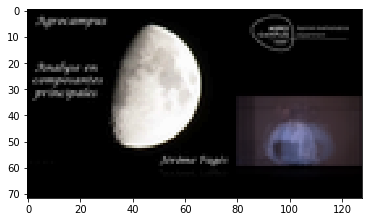

------------------------------ 
Slide n°  40
Première image :
https://youtu.be/uV5hmpzmWsU?t=5793s


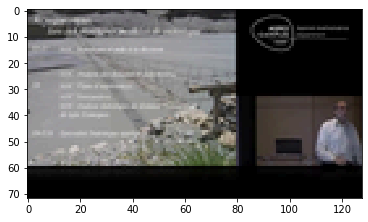

Image moyenne de tout le cluster
(Nombre d'images dans le cluster :3)


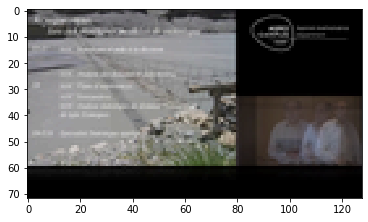

In [23]:
for g in range(max(final_clusters)):
    g = g + 1
    print('-'*30,"\nSlide n° ", g)
    km_centers = np.where(final_clusters == g)[0] # renvoie les indexes des centres issus du kmeans qui ont été groupés dans le groupe g après la classification hiérarchique
    img_ind = np.where([c in km_centers for c in clusters_kmeans]) # renvoie les indexes des images similaires, groupées par kmeans puis par classification hiérarchique
    same_slide = video.iloc[img_ind] # renvoie toutes les images montrant une même slide
    first_image = same_slide.sort_values("position").iloc[0]
    
    print("Première image :")
    display_image(video, first_image["position"])
    
    print("Image moyenne de tout le cluster")
    print("(Nombre d'images dans le cluster :{})".format(len(same_slide)))

    average_image = same_slide.iloc[:,1:].mean()   
    display_with_pylab(np.array(average_image))